# 시계열 예측 전처리 + 모델링

### data import

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models, layers
import seaborn as sns

filename = 'shampoo-three-year.csv'

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [36]:
dataset = pd.read_csv(filename)

In [37]:
dataset = dataset.dropna()

In [38]:
dataset.shape

(36, 2)

### data preview

In [5]:
dataset.head(30)

,Month,Sales of shampoo over a three year period
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


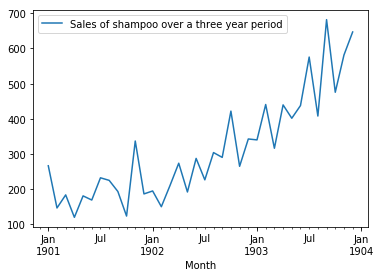

In [6]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
dataset.plot()
plt.show()

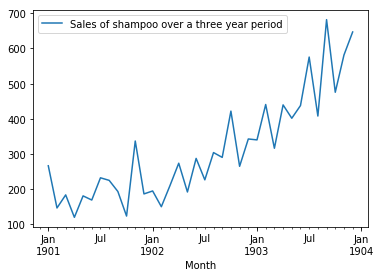

In [7]:
dataset.plot()
plt.rcParams['figure.figsize'] = (20,16)
plt.show()

## data preprocessing

#### make n-step to n-step forecast dataset

In [8]:
dataset.values

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [9]:
"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)
        

In [10]:
x_train, x_test, y_train, y_test = make_timeseries_dataset(series=dataset.values, x_steps=3, y_steps=1, test_size=0.2)

In [11]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (26, 3)
training Y data shape: (26, 1)
test X data shape: (7, 3)
test Y data shape: (7, 1)


# Modeling 1. Prophet

In [12]:
!pip install pystan fbprophet

Prophet follows the sklearn model API. 
We create an instance of the Prophet class and then call its fit and predict methods.

In [13]:
from fbprophet import Prophet

### banila prediction (monthly)

In [14]:
dataset = pd.read_csv(filename)
dataset.columns = ['ds', 'y']
dataset.head()

,ds,y
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [15]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')

In [17]:
forecast_data = m.predict(future_data)

In [18]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,581.871518,502.079415,672.413439
33,1903-10-01,491.845550,411.531406,579.137328
34,1903-11-01,540.990388,461.409636,624.766780
35,1903-12-01,569.817744,492.873066,657.708542
36,1903-12-31,500.759688,419.258567,586.588122


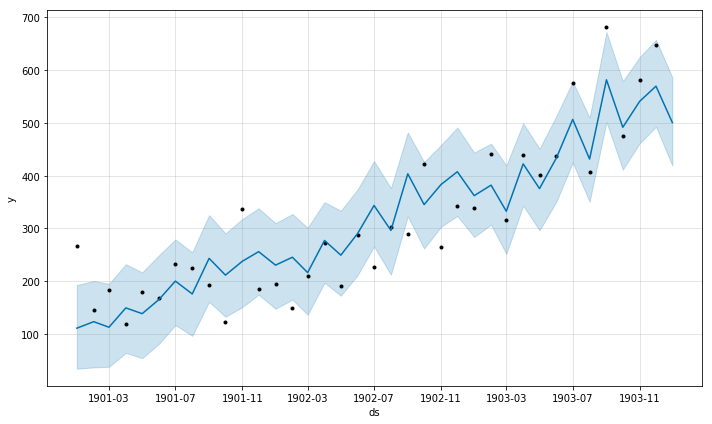

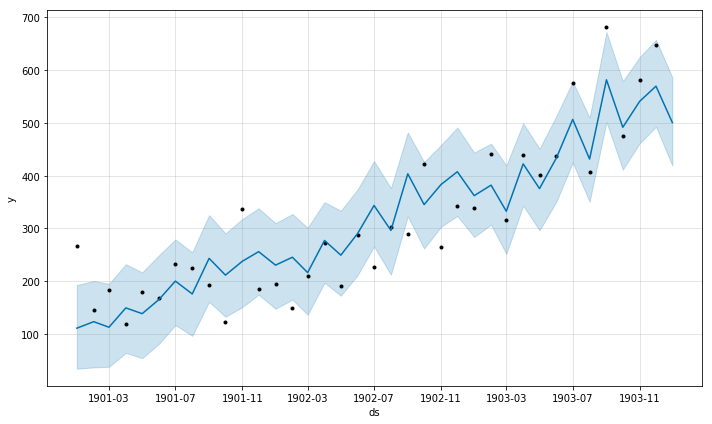

In [19]:
m.plot(forecast_data)

In [20]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1901-01-01,117.291396,34.037972,192.693195,117.291396,117.291396,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,0.0,0.0,0.0,110.876249
1,1901-02-01,128.037159,36.530384,200.644064,128.037159,128.037159,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,0.0,0.0,0.0,123.218289
2,1901-03-01,137.743009,37.672501,194.832217,137.743009,137.743009,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,0.0,0.0,0.0,112.697259
3,1901-04-01,148.488772,64.157023,232.261125,148.488772,148.488772,0.005806,0.005806,0.005806,0.005806,0.005806,0.005806,0.0,0.0,0.0,149.350918
4,1901-05-01,158.887897,53.970176,216.713455,158.887897,158.887897,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,0.0,0.0,0.0,138.434781


### apply saturating forecasting

- logistic growth 형태(상한과 하한이 있는 모형)로 예측 모델을 만들어 주는것.
- 일반적인 시계열 예측 모델은 saturating point가 있기 때문.

In [21]:
df_saturating = dataset
df_saturating['cap'] = 400
df_saturating['floor'] = 300

# month data fit : mode parameter setting
m = Prophet(growth='logistic', seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df_saturating)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [22]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
future_data['cap'] = 400
future_data['floor'] = 300
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,420.497187,275.570643,560.931433
33,1903-10-01,396.816812,232.502793,550.994325
34,1903-11-01,400.333321,253.378189,553.004538
35,1903-12-01,422.099080,271.763856,565.525511
36,1903-12-31,380.605378,229.132758,538.431351


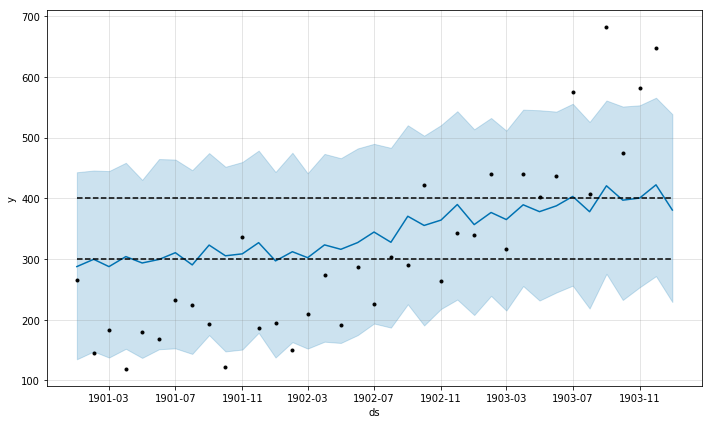

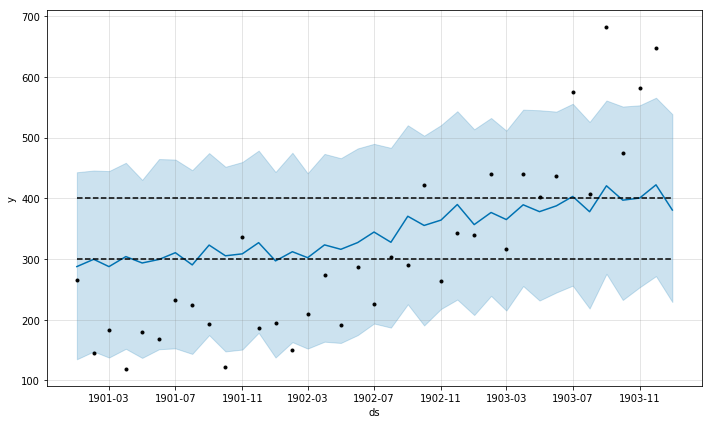

In [23]:
m.plot(forecast_data)

### outlier가 포함된 시계열 예측

In [24]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = 850
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = 10

In [25]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,548.703761,407.491003,681.560220
33,1903-10-01,469.533135,336.960719,605.171051
34,1903-11-01,523.177099,383.896514,661.653336
35,1903-12-01,415.586594,277.865620,554.536119
36,1903-12-31,502.178388,365.661751,620.243950


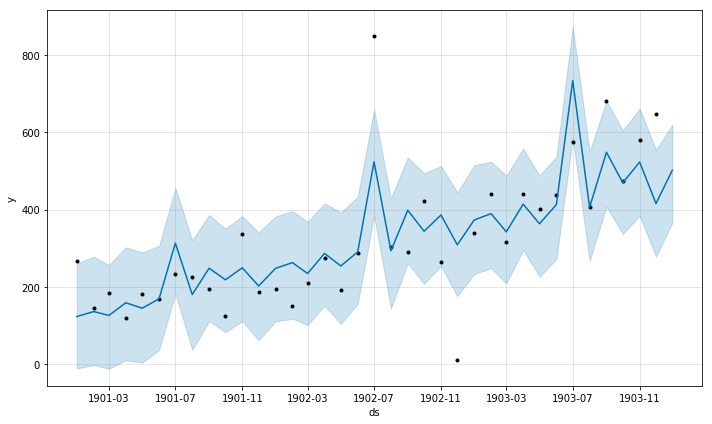

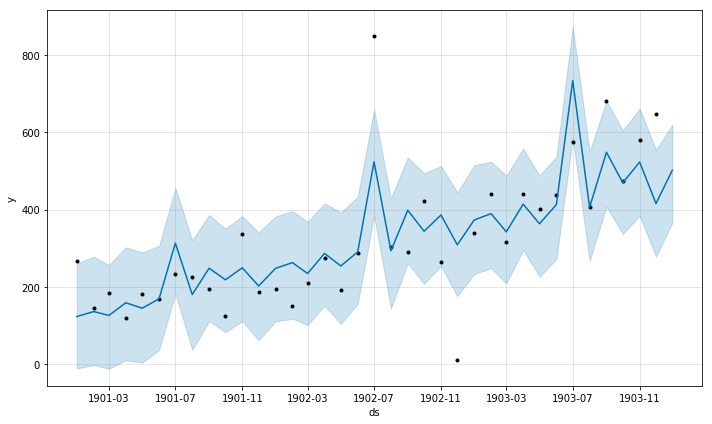

In [27]:
m.plot(forecast_data)

### rm outlier

In [28]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = None
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = None

In [29]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,575.752200,497.034852,650.870985
33,1903-10-01,488.268345,412.664350,571.475245
34,1903-11-01,535.208522,459.202506,616.347727
35,1903-12-01,602.970974,530.239595,683.270068
36,1903-12-31,484.517788,405.669520,559.652362


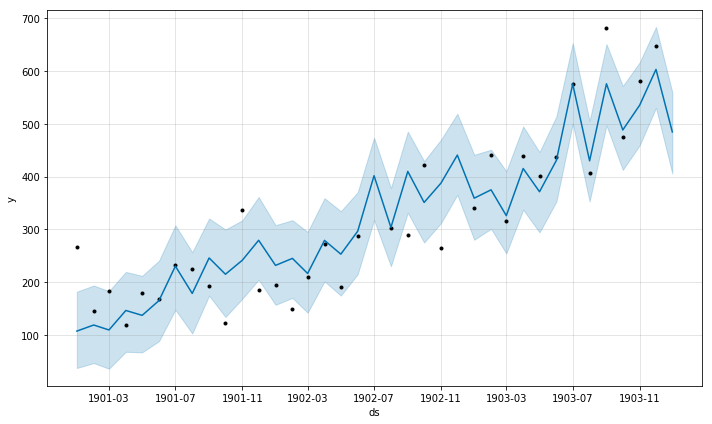

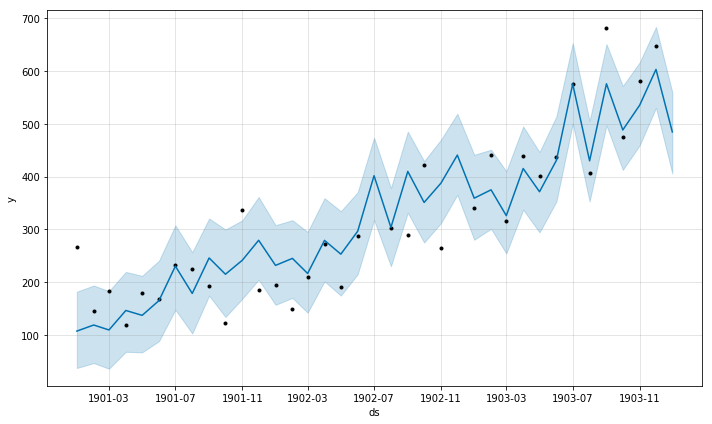

In [31]:
m.plot(forecast_data)

## Modeling 2. ARIMA(Autoregressive Integrated Moving Average)

- ARIMA는 Autoregressive Integrated Moving Average의 약자로, Autoregressive는 자기회귀 모형을 의미하고, Moving Average는 이동평균 모형을 의미한다.
- AR(Autoregression), 자기회귀 모형 : 이전의 자신의 관측값이 이후의 자신의 관측값에 영향을 준다는 아이디어의 모형이다. 큰 틀에서의 의미는 RNN과 완전히 동일하다. 다만, 선형적인 관계만을 정의하므로 정확하지는 않다.
- AR의 수식 : AR(1) -> Xt = theta * Xt-1 + et

- MA(Moving Average), 이동평균 모형 : 현재의 관측값이 이전의 관측 오차항에 영향을 받는다는 아이디어의 모형이다. 
- MA(1) -> Xt = et - B1 * et-1

- 이를 합한 ARMA 모형은 다음과 같다. 
- Xt=ϕXt−1+Wt+θWt−1
- 즉 정상성이 보장된다는 조건 하에 p차까지 자기회귀를 하고, 남은 잔차의 상관관계를 이용하여 오차항을 만들어내는 모형이다.
- ARIMA에서 I는 Integrated를 의미하는데, ARMA에서 시계열의 비정상성을 설명하기 위해 차분방정식의 개념을 도입하여 보정한 것을 의미하는 용어이다.

--------

- ARIMA의 하이퍼 파라미터는 3가지이다.
- (p, d , q)의 세 가지로, p와 q는 각각 AR, MA의 lag 개수를 의미하며 d는 차분의 횟수를 의미한다.

<img src="images/ARIMA.png">

### hyper parameter를 선정하는 방법
- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 yt와 yt-k 두 관측치의 관련성을 측정하는 함수
- 두 그래프 중, 감소폭이나 증가폭이 완만한 그래프가 더 강한 영향을 미치는 것이라고 볼 수 있다.

- 시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
- 반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
- 급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 
- 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

In [62]:
dataset = pd.read_csv(filename)
dataset.columns = ['Month', 'sale']
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
series = dataset

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


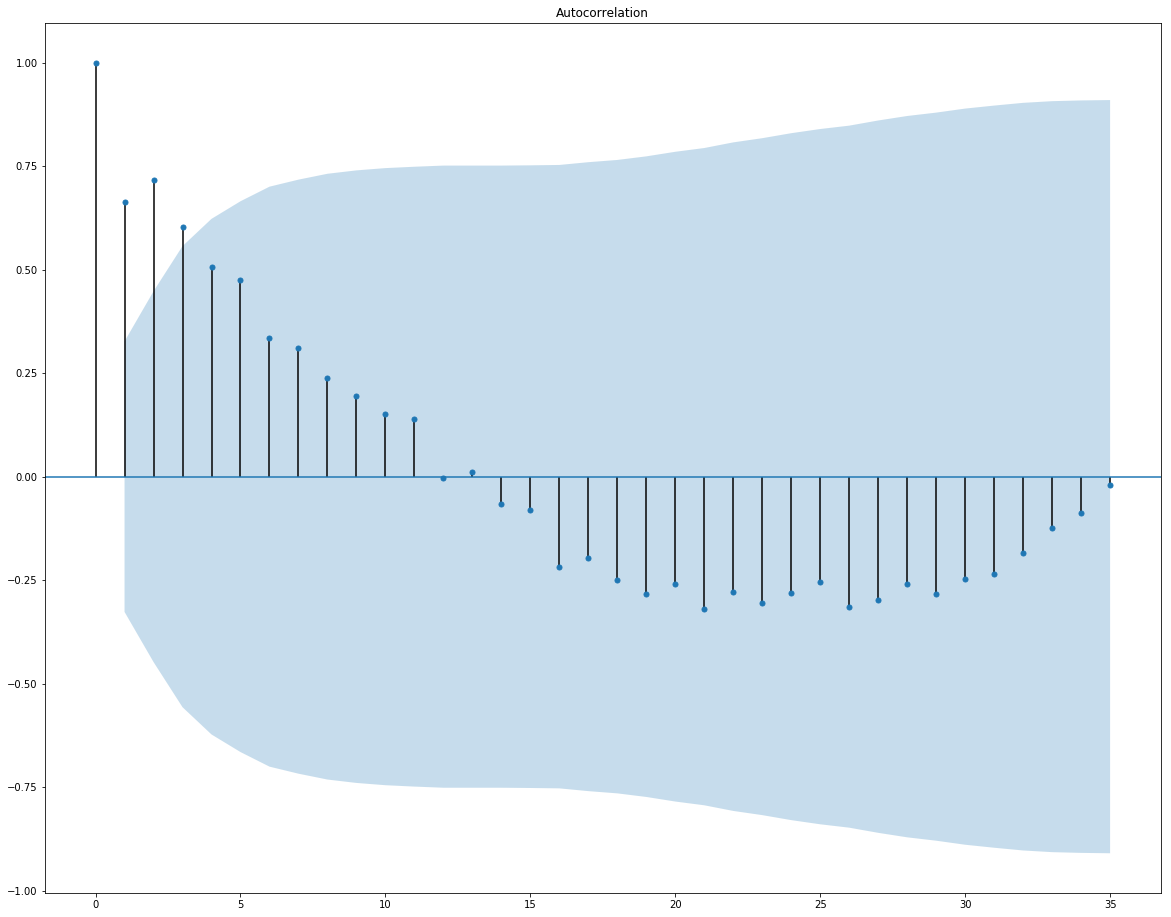

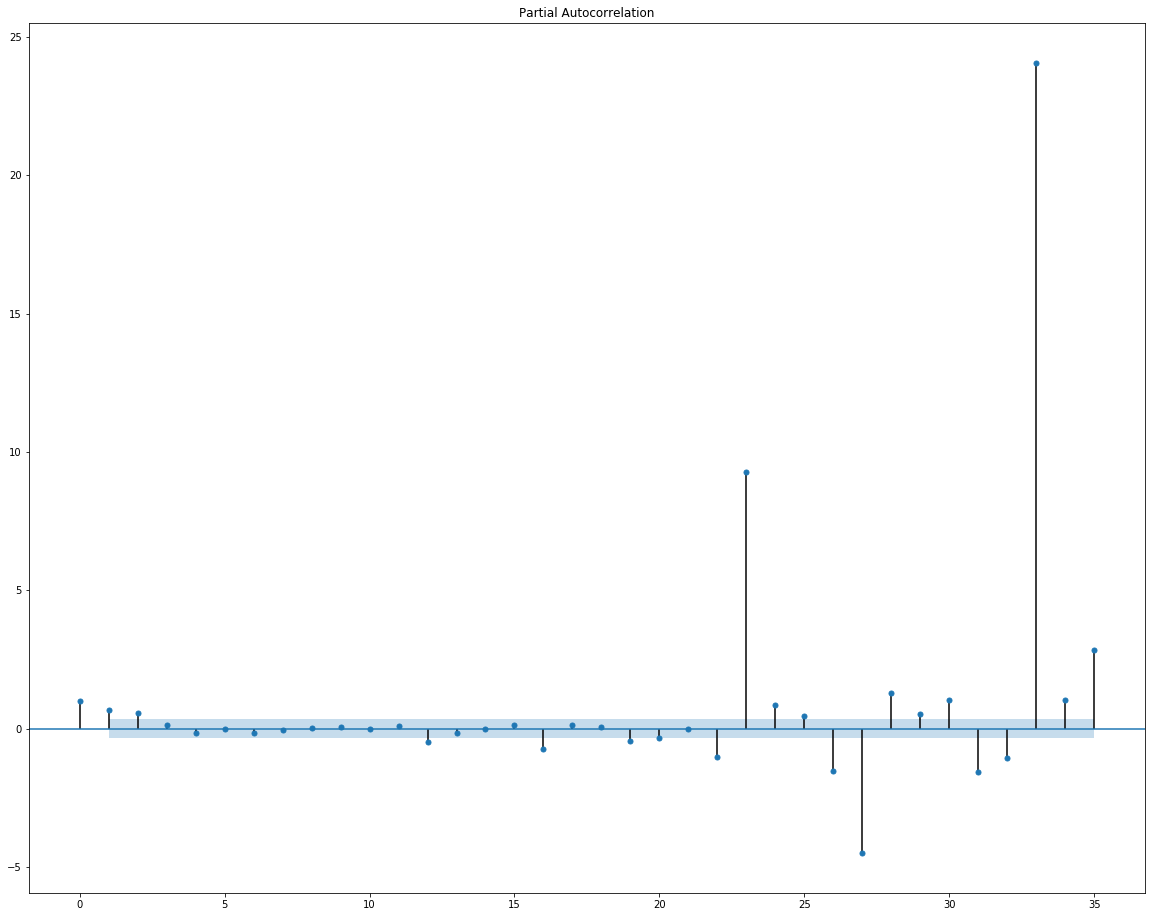

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

#### ARIMA 모델링

In [98]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(1,0,0)) # P>|z| -> 학습 계수에 대한 p-value 값으로, (a,b,c) 일때 가장 적절한 조합을 찾아야 한다.
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                   sale   No. Observations:                   36
Model:                     ARMA(1, 0)   Log Likelihood                -218.079
Method:                       css-mle   S.D. of innovations            102.235
Date:                Mon, 27 Aug 2018   AIC                            442.157
Time:                        11:00:03   BIC                            446.908
Sample:                    01-01-1901   HQIC                           443.815
                         - 12-01-1903                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        333.2378     64.289      5.183      0.000     207.234     459.242
ar.L1.sale     0.7509      0.118      6.360      0.000       0.520       0.982
                                    Roots           

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = ou

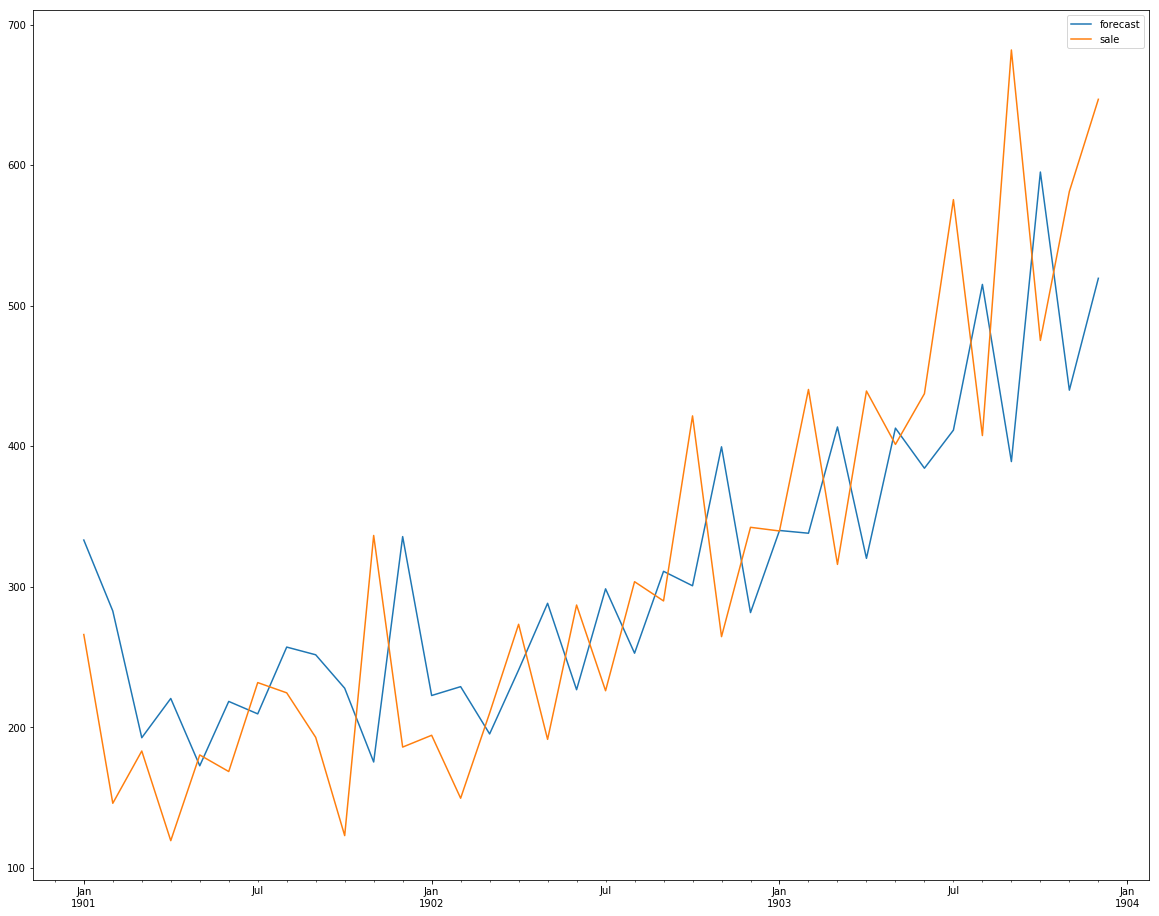

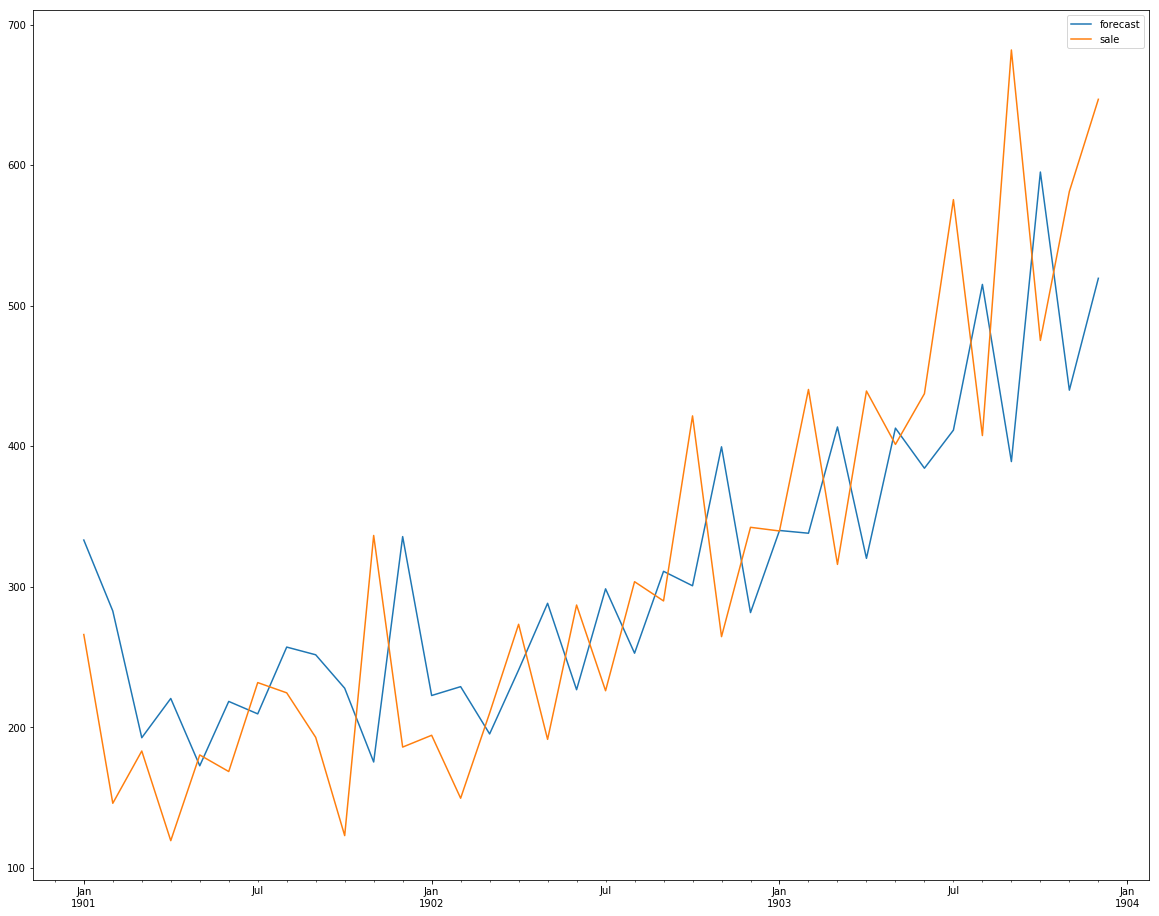

In [99]:
model_fit.plot_predict()

In [101]:
fore = model_fit.forecast(steps=3)
print(fore)

(array([568.7749614 , 510.10882218, 466.05488055]), array([102.23498718, 127.85057112, 140.24696386]), array([[368.39806856, 769.15185423],
       [259.52630739, 760.69133697],
       [191.17588244, 740.93387865]]))


## Modeling 3. LSTM

In [105]:
import os
import math
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [107]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)


"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(dataset.values)
x_train, x_test, y_train, y_test = make_timeseries_dataset(series=scaled_series, x_steps=3, y_steps=1, test_size=0.2)

In [ ]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
 
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)
 
# predict last value (or tomorrow?)
lastX = nptf[-1]
lastX = np.reshape(lastX, (1, 1, 1))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측
 
# plot
plt.plot(testPredict)
plt.plot(testY)
plt.show()

In [109]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

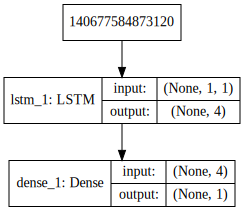

In [111]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Modeling 4. bitcoin data with LSTM

https://www.blockchain.com/ko/charts/market-price?timespan=60days